Set parameters

In [1]:
input_path = '/media/abraham/Data/DATA_PREPROCESSED/2025_MSL_ITI_Prisma_DePino/'
output_path = '/home/abraham/Documents/GitHub/NeuroComp2025_TPFinal/Data/TimeSeries/'
atlas_file = '/home/abraham/Documents/GitHub/NeuroComp2025_TPFinal/Data/Atlas/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S2_MNI152NLin6Asym_2mm.nii.gz'

# Options to clean the BOLD data
detrend = True
standarize = True # Set to unit variance
low_pass = 0.08
high_pass = 0.009


Install dependencies

In [2]:
%pip install nilearn
%pip install matplotlib
%pip install pybids

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Auxiliary functions

In [3]:
def load_confounds(file_list):
    import numpy as np
    confounds = np.genfromtxt(file_list[0], unpack=True)
    for f in file_list[1:]:
        confounds = np.vstack([confounds, np.genfromtxt(f, unpack=True)])
    return confounds.transpose()

Main processing

Found 41 subjects:
['01', '02', '03', '04', '05', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44']
TR = 0.5s
Processing subject sub-01
	Timeseries file exists. Skipping...
Processing subject sub-02
	Timeseries file exists. Skipping...
Processing subject sub-03
	Timeseries file exists. Skipping...
Processing subject sub-04
	Timeseries file exists. Skipping...
Processing subject sub-05
	Timeseries file exists. Skipping...
Processing subject sub-08
	Timeseries file exists. Skipping...
Processing subject sub-09
	Timeseries file exists. Skipping...
Processing subject sub-10
	Timeseries file exists. Skipping...
Processing subject sub-11
	Timeseries file exists. Skipping...
Processing subject sub-12
	Cleaning data...
	Extracting timeseries...
	Saving timeseries...
	Plotting...


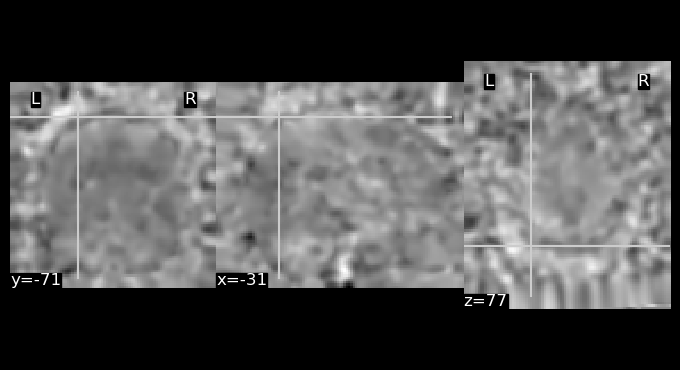

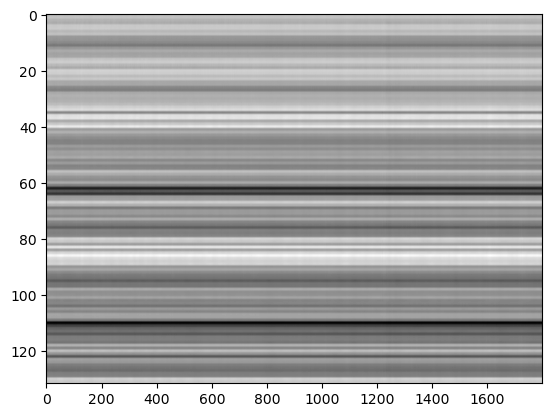

	Done
Processing subject sub-13
	Cleaning data...
	Extracting timeseries...
	Saving timeseries...
	Plotting...


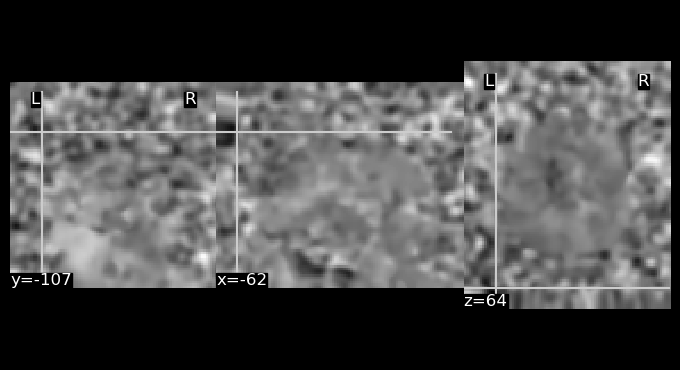

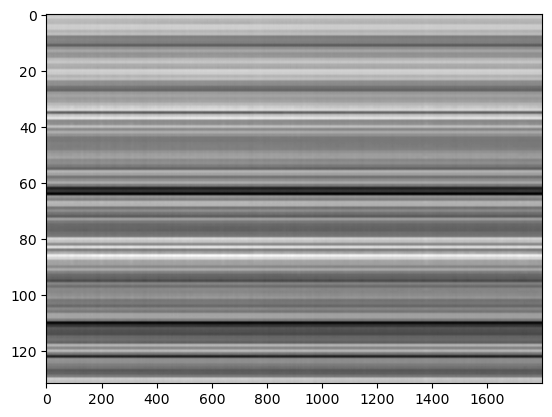

	Done
Processing subject sub-14
	Cleaning data...
	Extracting timeseries...
	Saving timeseries...
	Plotting...


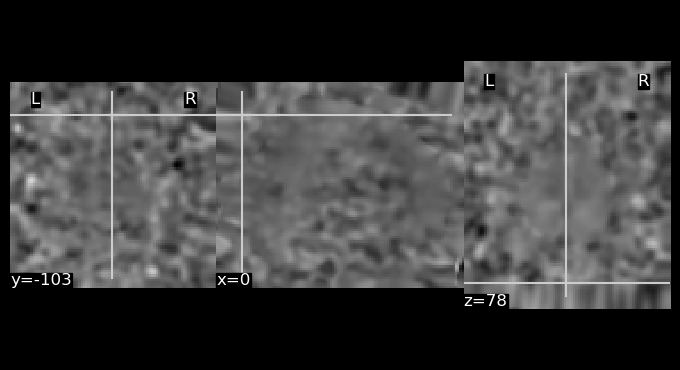

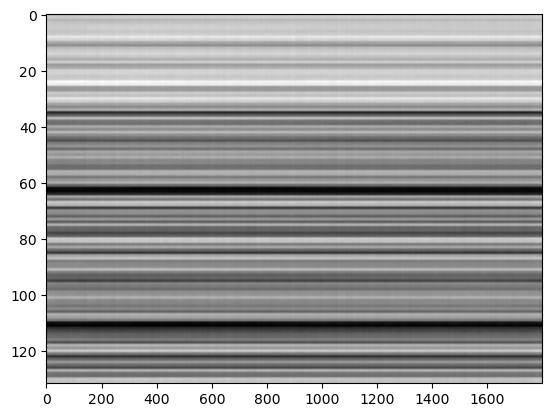

	Done
Processing subject sub-15
	Cleaning data...
	Extracting timeseries...
	Saving timeseries...
	Plotting...


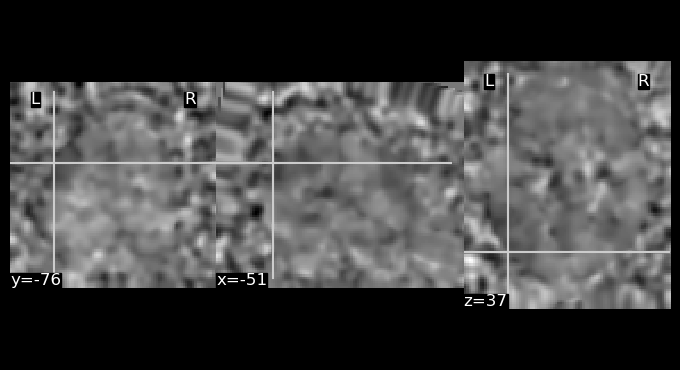

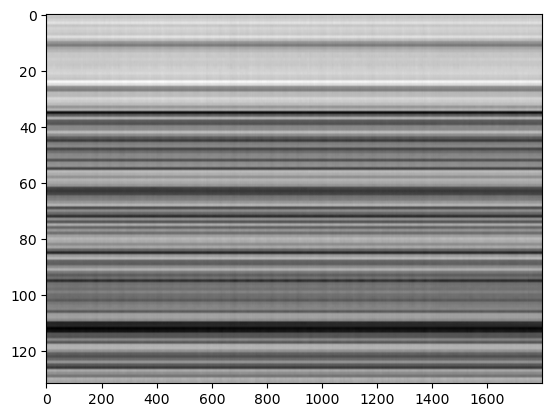

	Done
Processing subject sub-16
	Cleaning data...
	Extracting timeseries...
	Saving timeseries...
	Plotting...


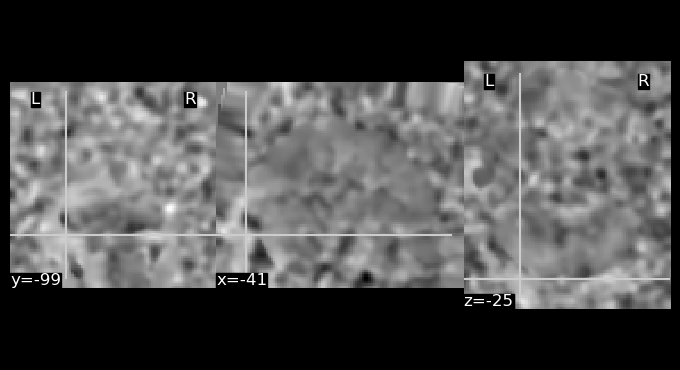

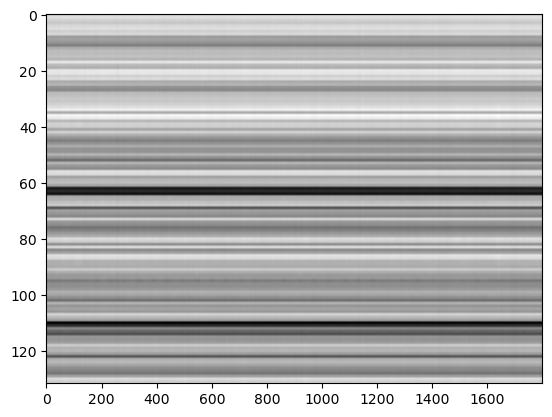

	Done
Processing subject sub-17
	Cleaning data...
	Extracting timeseries...
	Saving timeseries...
	Plotting...


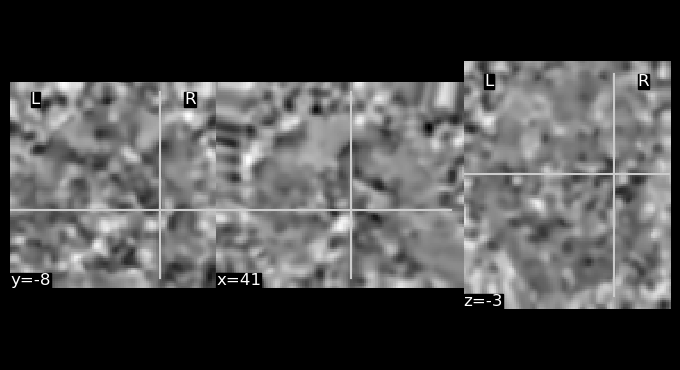

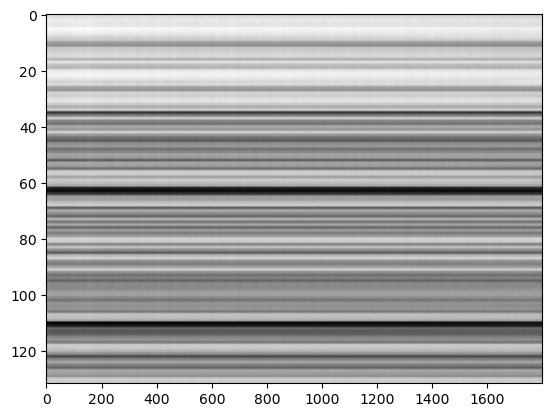

	Done
Processing subject sub-18
	Cleaning data...


In [ ]:
from bids import BIDSLayout
from nilearn.image import clean_img, index_img
from nilearn.maskers import NiftiLabelsMasker
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np
import os


layout = BIDSLayout(input_path, derivatives=True) # Load data in BIDS format

subjects = layout.get_subjects()
print(f'Found {len(subjects)} subjects:')

print(subjects)
tr = layout.get_tr() # Should be the same for every subject and BOLD file
print(f'TR = {tr}s')

masker = NiftiLabelsMasker(labels_img=atlas_file, standarize=False) # Make masks from the atlas

# Iterate over subjects (each has only one BOLD file)
for sub_id in subjects:
    print(f'Processing subject sub-{sub_id}')
    
    # Get and verify the BOLD data
    bold_file = layout.get(
        subject = sub_id,
        suffix = 'bold',
        extension = ['.nii', '.nii.gz'],
        desc = 'smooth',
        space = 'IXI549Space' # SPM's standard space, practically identical to MNI152
    )
    if len(bold_file) != 1:
        raise RuntimeError('Got a number of BOLD files different than one') # Check that it gets a list of one file
    bold_file = bold_file[0] # Get the only BIDS object from the list
    entities = bold_file.entities # Get BIDS entities like 'task'
    bold_file = bold_file.path # Get the path from the BIDS object

    # Get confounds (realignment parameters (hmc), WM signal and CSF signal) and verify
    confounds_files = layout.get(
        subject = sub_id,
        suffix = 'timeseries',
        desc = ['hmc', 'csf', 'wm'],
        extension = ['.txt'],
    )
    if len(confounds_files) != 3:
        raise RuntimeError('Got a number of confounds files different than three')
    confounds_files = [f.path for f in confounds_files] # Get paths, not BIDS objects
    confounds = load_confounds(confounds_files) # Load the all the confounds data into a single matrix
    
    # Construct the output filename
    task_id = entities['task'] # The only entity of interest in this case
    output_filename = f'sub-{sub_id}_task-{task_id}_desc-clean_timeseries.tsv' # BIDS-like
    output_file = os.path.join(output_path, output_filename)
    if os.path.exists(output_file):
        print('\tTimeseries file exists. Skipping...')
        continue

    # Clean the BOLD data. May take a few minutes and use a lot of RAM
    print('\tCleaning data...')
    clean_data = clean_img(
        imgs = bold_file,
        confounds = confounds,
        detrend = detrend,
        standarize = standarize,
        low_pass = low_pass,
        high_pass = high_pass,
        t_r = tr
    )

    print('\tExtracting timeseries...')
    timeseries = masker.fit_transform(bold_file) # Extract temporal mean from each label in the atlas

    print('\tSaving timeseries...')
    np.savetxt(output_file, timeseries, delimiter='\t')

    print('\tPlotting...')
    # Plot the first volume of the clean data
    plotting.plot_epi(index_img(clean_data, 0), cmap='gray')
    plotting.show()    
    # Plot the extracted timeseries
    plt.imshow(timeseries.transpose(), aspect='auto', cmap='gray')
    plt.show()

    del clean_data
    del timeseries

    print('\tDone')
    
    
